# LASSO Model

### Score: 0.18415
The target variable is: 

amount_new_house_transactions: The total monetary value of new house transactions in 10,000 yuan.

We are using some of the features found in the different csv's to predict the final amount
The method used is LassoCV with cross validation

# 1. SETUP - Dependencies, dataloading

## 1.1 Dependencies and plotting style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import sklearn

from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from datetime import datetime

In [2]:
# Set global plot styles
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 1.2 Loads all necessary data without any processing

We first define the datapath

In [3]:
# Define the data path
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")

We load the complementary datasets which will include many of the features

In [4]:
# Transaction Data (Monthly)
new_house = pd.read_csv(DATA_PATH / "train" / "new_house_transactions.csv")
pre_owned = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions.csv")
land = pd.read_csv(DATA_PATH / "train" / "land_transactions.csv")

# Nearby Sectors Transaction Data
new_house_nearby = pd.read_csv(DATA_PATH / "train" / "new_house_transactions_nearby_sectors.csv")
pre_owned_nearby = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions_nearby_sectors.csv")
land_nearby = pd.read_csv(DATA_PATH / "train" / "land_transactions_nearby_sectors.csv")

# Sector Features (Static)
sector_poi = pd.read_csv(DATA_PATH / "train" / "sector_POI.csv")

# Market Indicators (Time-series)
search_index = pd.read_csv(DATA_PATH / "train" / "city_search_index.csv")
city_indexes = pd.read_csv(DATA_PATH / "train" / "city_indexes.csv")

# Convert month columns to datetime for datasets that have it
datasets_with_month = [new_house, pre_owned, land, new_house_nearby, pre_owned_nearby, land_nearby, search_index]

for df in datasets_with_month:
    if 'month' in df.columns:
        df['month'] = pd.to_datetime(df['month'])

# Store in dictionary for easy access
datasets = {
    'new_house': new_house,
    'pre_owned': pre_owned,
    'land': land,
    'new_house_nearby': new_house_nearby,
    'pre_owned_nearby': pre_owned_nearby,
    'land_nearby': land_nearby,
    'sector_poi': sector_poi,
    'search_index': search_index,
    'city_indexes': city_indexes
}

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8709/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8709/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8709/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8709/712092853

In [5]:
new_house.tail()

,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,period_new_house_sell_through
5428,2024-07-01,sector 91,70,7921,40967,32450.06,113,463.57,2133.0,341192.0,51.82
5429,2024-07-01,sector 92,211,22084,13949,30804.74,105,145.99,5908.0,636696.0,34.76
5430,2024-07-01,sector 93,62,8136,27452,22335.30,131,360.25,1323.0,150862.0,27.74
5431,2024-07-01,sector 94,44,5078,26367,13389.41,115,304.30,2027.0,215821.0,38.62
5432,2024-07-01,sector 96,1,140,40079,561.19,140,561.19,1.0,195.0,1.39


# 3. DATA & FEATURE ENGINEERING - Merging, cleaning, handling missing values


In [6]:
# ------------------------------------------
# 3.1 Create Master Dataset
# ------------------------------------------

# Start with new_house as base (contains target)
df = new_house.copy()

# Define target variable
target_col = 'amount_new_house_transactions'

# MINIMAL feature selection - only the most essential
columns_to_merge = {
    'pre_owned': [
        'month', 'sector',
        'amount_pre_owned_house_transactions',  # Direct substitute market
        'price_pre_owned_house_transactions'    # Price signals
    ],
    'new_house_nearby': [
        'month', 'sector',
        'amount_new_house_transactions_nearby_sectors'  # Spatial spillover
    ],
}

# Merge only essential datasets
for data, name in [(pre_owned, 'pre_owned'), 
                   (new_house_nearby, 'new_house_nearby')]:
    
    cols_to_use = [col for col in columns_to_merge[name] if col in data.columns]
    df = df.merge(data[cols_to_use], on=['month', 'sector'], how='left')
    print(f"Merged {name}: added {len(cols_to_use)-2} features, shape: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Base features (excluding target): {df.shape[1] - 1}")

# ------------------------------------------
# 3.2 Add Seasonal Dummy Variables
# ------------------------------------------

# Create dummy variables for peak and low months
df['is_december'] = (df['month'].dt.month == 12).astype(int)
df['is_february'] = (df['month'].dt.month == 2).astype(int)

# Verify the seasonal patterns
dec_avg = df[df['is_december'] == 1][target_col].mean()
feb_avg = df[df['is_february'] == 1][target_col].mean()
other_avg = df[(df['is_december'] == 0) & (df['is_february'] == 0)][target_col].mean()

print(f"Seasonal patterns in {target_col}:")
print(f"  December (peak): {dec_avg:,.0f}")
print(f"  February (low):  {feb_avg:,.0f}")
print(f"  Other months:    {other_avg:,.0f}")
print(f"\nAdded 2 dummy variables: is_december, is_february")
print(f"Updated dataset shape: {df.shape}")

# ==========================================
# 3.3 MINIMAL FEATURE ENGINEERING
# ==========================================

# Sort for lag calculations
df = df.sort_values(['sector', 'month']).reset_index(drop=True)

# 3. Essential time features
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter
df['year'] = df['month'].dt.year

# 4. One key ratio
if 'price_pre_owned_house_transactions' in df.columns:
    df['new_to_preowned_price_ratio'] = (
        df['price_new_house_transactions'] / 
        df['price_pre_owned_house_transactions'].replace(0, np.nan)
    )

print(f"\nFinal feature count: {df.shape[1] - 3}")  # -3 for month, sector, target

# ------------------------------------------
# 3.6 Create Lagged Features (No Data Leakage)
# ------------------------------------------

print("\n" + "="*60)
print("CREATING LAGGED FEATURES FOR TIME SERIES FORECASTING")
print("="*60)

# Sort by sector and time to ensure proper lagging
df = df.sort_values(['sector', 'month']).reset_index(drop=True)

# Keep original features (we'll need them for generating features on future data)
features_to_lag = [
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]

# Create 1-month lags
for feature in features_to_lag:
    if feature in df.columns:
        lag_col_name = f'{feature}_lag1'
        df[lag_col_name] = df.groupby('sector')[feature].shift(1)
        non_null = df[lag_col_name].notna().sum()
        print(f"{lag_col_name}: {non_null}/{len(df)} non-null values")

# Create sector-level historical averages (no leakage)
print(f"\nCreating sector historical features...")
df['sector_historical_mean'] = df.groupby('sector')[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
df['sector_historical_std'] = df.groupby('sector')[target_col].transform(
    lambda x: x.expanding().std().shift(1)
)

# Create month-level historical averages across all sectors (seasonal patterns)
df['month_historical_mean'] = df.groupby(df['month'].dt.month)[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)

# Sector-month combination average (sector-specific seasonal pattern)
df['sector_month_avg'] = df.groupby(['sector', df['month'].dt.month])[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)

# Time trend per sector (how much growth/decline over time)
df['months_since_start'] = df.groupby('sector').cumcount()

print(f"sector_historical_mean: {df['sector_historical_mean'].notna().sum()}/{len(df)} non-null")
print(f"sector_historical_std: {df['sector_historical_std'].notna().sum()}/{len(df)} non-null")
print(f"month_historical_mean: {df['month_historical_mean'].notna().sum()}/{len(df)} non-null")
print(f"sector_month_avg: {df['sector_month_avg'].notna().sum()}/{len(df)} non-null")

# Keep time features
print(f"\nTime features: is_december, is_february, year, months_since_start")

# DON'T drop original features - keep them for future feature generation
print(f"\nKeeping original features for future predictions")

# Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

all_features = [col for col in df.columns if col not in ['month', 'date', 'sector', target_col]]
print(f"Final feature count: {len(all_features)}")
print(f"Features: {all_features}")
print(f"\nRows with complete lag data: {df.dropna().shape[0]}/{len(df)}")

Merged pre_owned: added 2 features, shape: (5433, 13)
Merged new_house_nearby: added 1 features, shape: (5433, 14)

Dataset shape: (5433, 14)
Base features (excluding target): 13
Seasonal patterns in amount_new_house_transactions:
  December (peak): 46,470
  February (low):  19,798
  Other months:    32,619

Added 2 dummy variables: is_december, is_february
Updated dataset shape: (5433, 16)

Final feature count: 17

CREATING LAGGED FEATURES FOR TIME SERIES FORECASTING
num_new_house_available_for_sale_lag1: 5326/5433 non-null values
amount_pre_owned_house_transactions_lag1: 4698/5433 non-null values
period_new_house_sell_through_lag1: 5326/5433 non-null values

Creating sector historical features...
sector_historical_mean: 5338/5433 non-null
sector_historical_std: 5244/5433 non-null
month_historical_mean: 5421/5433 non-null
sector_month_avg: 4318/5433 non-null

Time features: is_december, is_february, year, months_since_start

Keeping original features for future predictions

FEATURE EN

In [7]:
# ------------------------------------------
# 3.7 Remove Data Leakage Columns
# ------------------------------------------

# These might directly calculate the target
potential_leakage = [
    'area_new_house_transactions',  # amount = area * price
    'total_price_per_unit_new_house_transactions',  # directly related to amount
    'price_new_house_transactions',   # directly related to amount
    'price_pre_owned_house_transactions',   # directly related to amount
    'quarter',  # might indirectly leak seasonal patterns
    'area_new_house_available_for_sale',
    'total_price_per_unit_pre_owned_house_transactions',  # directly related to amount
    'month_num',  # might indirectly leak seasonal patterns
    'num_new_house_transactions',    
    'area_per_unit_new_house_transactions',  # ADD
    'amount_new_house_transactions_nearby_sectors',  # ADD
    'new_to_preowned_price_ratio'  # ADD
]

df.drop(columns=[col for col in potential_leakage if col in df.columns], inplace=True)

print(f"Remaining columns: {len(df.columns)}")

# ------------------------------------------
# 3.8 Final Dataset Info
# ------------------------------------------

print("\n" + "="*40)
print("PREPROCESSING COMPLETE")
print("="*40)
print(f"Final dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(df.columns) - 1}")  # -1 for target

# Save processed data
output_path = Path("/Users/nikola/Python/KaggleCompetition/data")
df.to_csv(output_path / "processed_data_lasso.csv", index=False)
print(f"\nProcessed data saved to: {output_path / 'processed_data_lasso.csv'}")

# Keep a copy for modeling
df_processed = df.copy()

# ------------------------------------------
# 3.9 MAPE Competition Scoring Function
# ------------------------------------------

def custom_competition_score(y_true, y_pred):
    """
    Custom competition scoring function.
    
    Stage 1: If more than 30% of samples have absolute percentage errors > 100%, return 0
    Stage 2: Otherwise, calculate MAPE on samples with APE <= 1, scaled by fraction of valid samples
    
    Returns: Score between 0 and 1 (higher is better)
    """
    # Calculate absolute percentage errors
    ape = np.abs((y_pred - y_true) / y_true)
    
    # Stage 1: Check if more than 30% have errors > 100% (i.e., > 1.0)
    extreme_errors = np.sum(ape > 1.0) / len(ape)
    
    if extreme_errors > 0.3:
        return 0.0
    
    # Stage 2: Calculate MAPE on samples with APE <= 1
    valid_mask = ape <= 1.0
    
    if np.sum(valid_mask) == 0:
        return 0.0
    
    # D: set of valid samples (APE <= 1)
    valid_ape = ape[valid_mask]
    
    # Average MAPE of valid samples
    mape_valid = np.mean(valid_ape)
    
    # Fraction of valid samples
    fraction_valid = np.sum(valid_mask) / len(ape)
    
    # Scaled MAPE
    scaled_mape = mape_valid / fraction_valid
    
    # Final score: 1 - scaled_mape
    score = 1 - scaled_mape
    
    return max(0, score)  # Ensure non-negative

Remaining columns: 17

PREPROCESSING COMPLETE
Final dataset shape: (5433, 17)
Memory usage: 0.68 MB
Target variable: amount_new_house_transactions
Number of features: 16

Processed data saved to: /Users/nikola/Python/KaggleCompetition/data/processed_data_lasso.csv


## Visualisation

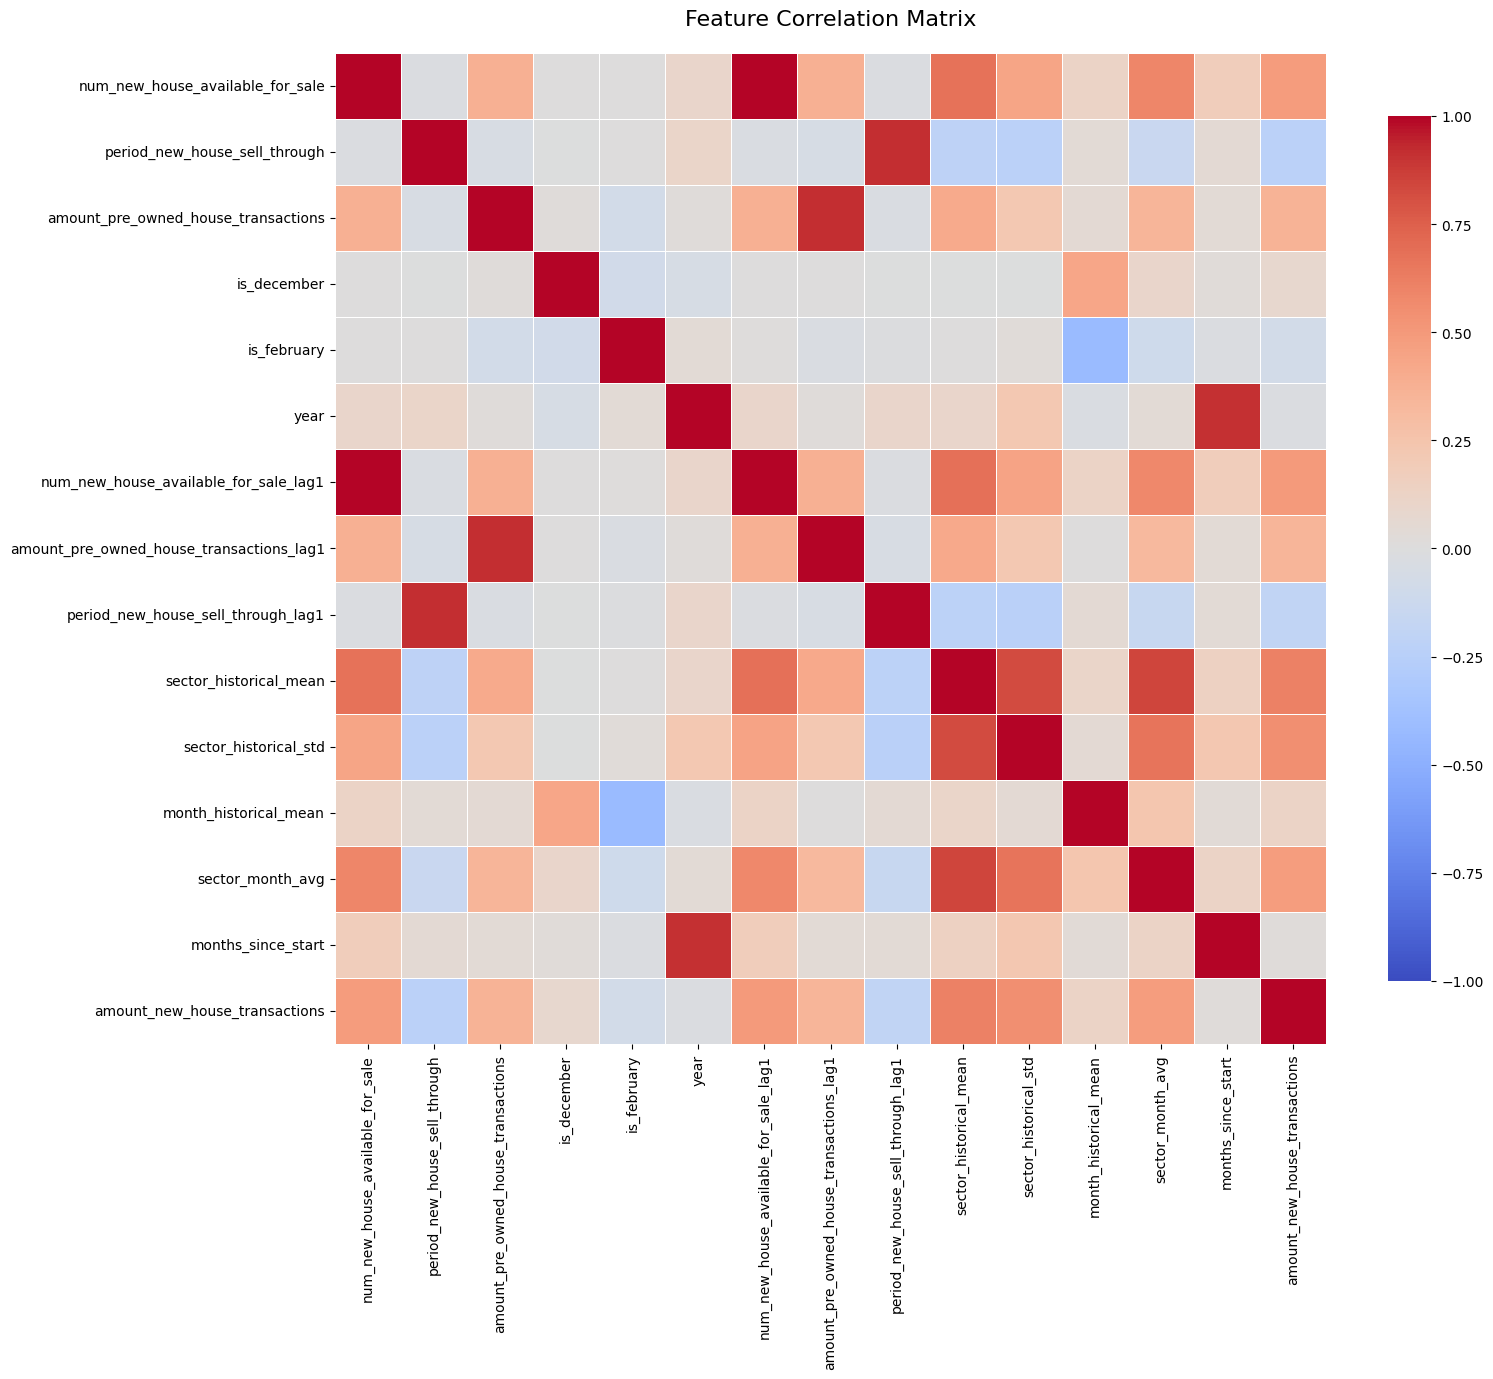


HIGHLY CORRELATED FEATURE PAIRS (|correlation| >= 0.8)
                          Feature 1                                Feature 2  Correlation
   num_new_house_available_for_sale    num_new_house_available_for_sale_lag1     0.992337
amount_pre_owned_house_transactions amount_pre_owned_house_transactions_lag1     0.917930
      period_new_house_sell_through       period_new_house_sell_through_lag1     0.916330
                               year                       months_since_start     0.909290
             sector_historical_mean                         sector_month_avg     0.844737
             sector_historical_mean                    sector_historical_std     0.821831

Total pairs found: 6


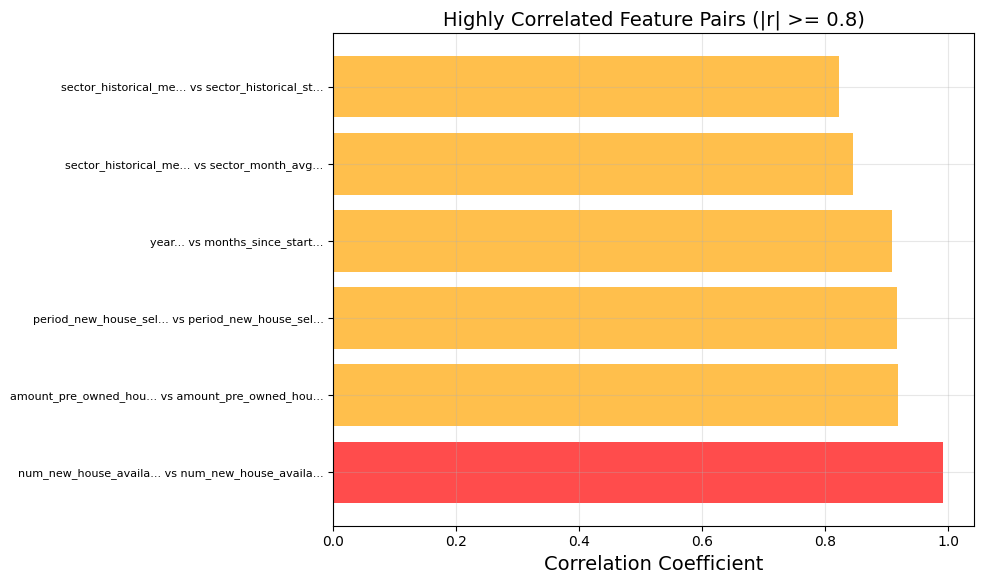

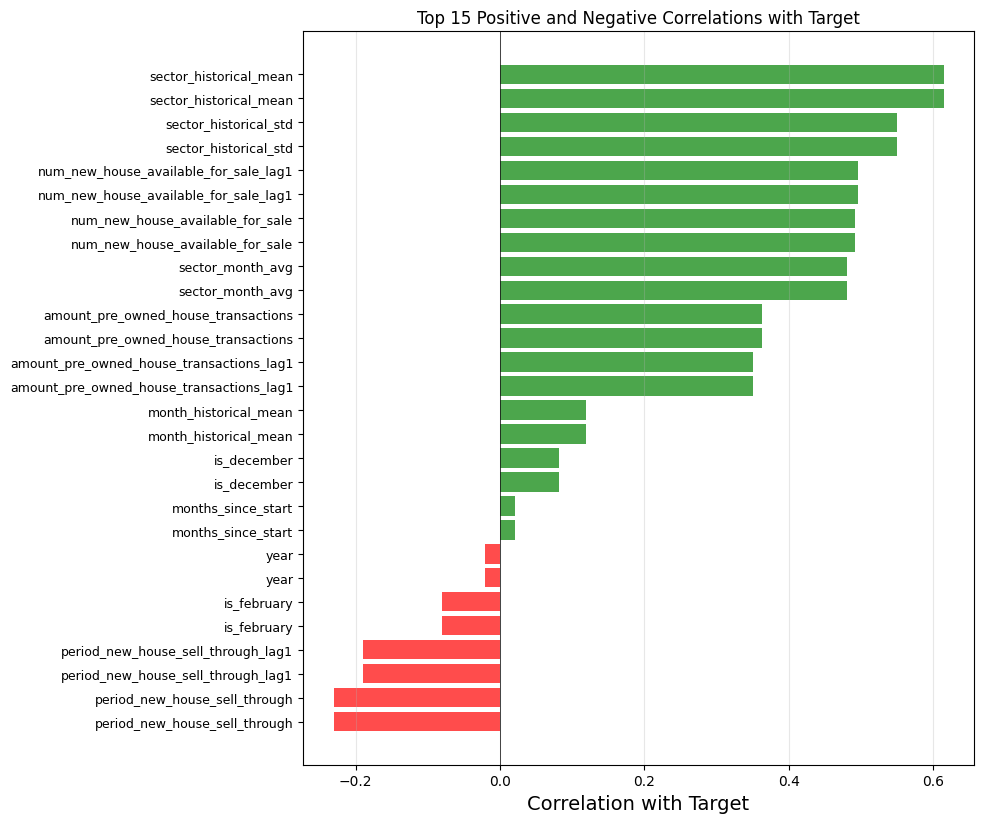


CORRELATION WITH TARGET STATISTICS
Highest positive correlation: 0.6142 (sector_historical_mean)
Highest negative correlation: -0.2305 (period_new_house_sell_through)
Mean absolute correlation: 0.2920
Features with |correlation| > 0.5: 2
Features with |correlation| > 0.3: 7


In [8]:
# ==========================================
# 3. FEATURE CORRELATION ANALYSIS
# ==========================================

# Calculate correlation matrix for all features
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

# Create correlation matrix
correlation_matrix = df[feature_cols + [target_col]].corr()

# ==========================================
# PLOT 1: Full Correlation Heatmap
# ==========================================
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=False,  # Set to True if you want to see values (can be crowded)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# ==========================================
# PLOT 2: High Correlation Pairs
# ==========================================

# Find highly correlated feature pairs (excluding target)
correlation_threshold = 0.8
feature_corr_matrix = df[feature_cols].corr()

# Get upper triangle to avoid duplicates
upper_triangle = np.triu(np.ones_like(feature_corr_matrix), k=1).astype(bool)
high_corr_pairs = []

for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_value = feature_corr_matrix.iloc[i, j]
        if abs(corr_value) >= correlation_threshold:
            high_corr_pairs.append({
                'Feature 1': feature_corr_matrix.columns[i],
                'Feature 2': feature_corr_matrix.columns[j],
                'Correlation': corr_value
            })

# Display high correlation pairs
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                               key=abs, 
                                                               ascending=False)
    print("\n" + "="*70)
    print(f"HIGHLY CORRELATED FEATURE PAIRS (|correlation| >= {correlation_threshold})")
    print("="*70)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs found: {len(high_corr_df)}")
    
    # Visualize high correlation pairs
    if len(high_corr_df) > 0:
        fig, ax = plt.subplots(figsize=(10, max(6, len(high_corr_df) * 0.4)))
        colors = ['red' if abs(x) > 0.95 else 'orange' for x in high_corr_df['Correlation']]
        ax.barh(range(len(high_corr_df)), high_corr_df['Correlation'], color=colors, alpha=0.7)
        ax.set_yticks(range(len(high_corr_df)))
        ax.set_yticklabels([f"{row['Feature 1'][:20]}... vs {row['Feature 2'][:20]}..." 
                            for _, row in high_corr_df.iterrows()], fontsize=8)
        ax.set_xlabel('Correlation Coefficient')
        ax.set_title(f'Highly Correlated Feature Pairs (|r| >= {correlation_threshold})')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print(f"\nNo feature pairs with |correlation| >= {correlation_threshold} found.")

# ==========================================
# PLOT 3: Top Correlations with Target
# ==========================================

# Get correlations with target variable
target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)

# Plot top positive and negative correlations
n_top = 15
top_positive = target_correlations.head(n_top)
top_negative = target_correlations.tail(n_top)
top_features = pd.concat([top_positive, top_negative]).sort_values()

fig, ax = plt.subplots(figsize=(10, max(8, len(top_features) * 0.3)))
colors = ['green' if x > 0 else 'red' for x in top_features]
ax.barh(range(len(top_features)), top_features, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index, fontsize=9)
ax.set_xlabel('Correlation with Target')
ax.set_title(f'Top {n_top} Positive and Negative Correlations with Target', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Print correlation statistics
print("\n" + "="*70)
print("CORRELATION WITH TARGET STATISTICS")
print("="*70)
print(f"Highest positive correlation: {target_correlations.max():.4f} ({target_correlations.idxmax()})")
print(f"Highest negative correlation: {target_correlations.min():.4f} ({target_correlations.idxmin()})")
print(f"Mean absolute correlation: {target_correlations.abs().mean():.4f}")
print(f"Features with |correlation| > 0.5: {(target_correlations.abs() > 0.5).sum()}")
print(f"Features with |correlation| > 0.3: {(target_correlations.abs() > 0.3).sum()}")

# 4. PANEL DATA - CROSS VALIDATION

In [9]:
# ==========================================
# 4.1 CROSS-VALIDATION SETUP
# ==========================================

print("="*60)
print("CROSS-VALIDATION SETUP")
print("="*60)

# Sort data by time (critical for time series)
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# Check data span
print(f"Data span: {df['month'].min()} to {df['month'].max()}")
print(f"Total months: {df['month'].nunique()}")
print(f"Total sectors: {df['sector'].nunique()}")
print(f"Total rows: {len(df)}")

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

print(f"\nFeatures for model: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df[target_col]

# Remove rows where target is NaN
mask = ~y.isna()
X = X[mask]
y = y[mask]
print(f"After removing NaN targets: {len(X)} rows")

# Simple TimeSeriesSplit
# For monthly data: test_size = number of months to use as test
# Let's use 6 months as test set for each fold
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=6 * df['sector'].nunique(),  # 6 months * number of sectors
    gap=0  # No gap needed for monthly data
)

# Display the splits
print("\nCross-validation splits:")
print("-" * 40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx):,} rows ({len(train_months)} months)")
    print(f"  Test:  {len(test_idx):,} rows ({len(test_months)} months)")
    print(f"  Test period: {test_months.min()} to {test_months.max()}")

CROSS-VALIDATION SETUP
Data span: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Total months: 67
Total sectors: 95
Total rows: 5433

Features for model: 14
After removing NaN targets: 5433 rows

Cross-validation splits:
----------------------------------------
Fold 1:
  Train: 2,583 rows (33 months)
  Test:  570 rows (8 months)
  Test period: 2021-09-01 00:00:00 to 2022-04-01 00:00:00
Fold 2:
  Train: 3,153 rows (40 months)
  Test:  570 rows (8 months)
  Test period: 2022-04-01 00:00:00 to 2022-11-01 00:00:00
Fold 3:
  Train: 3,723 rows (47 months)
  Test:  570 rows (8 months)
  Test period: 2022-11-01 00:00:00 to 2023-06-01 00:00:00
Fold 4:
  Train: 4,293 rows (54 months)
  Test:  570 rows (8 months)
  Test period: 2023-06-01 00:00:00 to 2024-01-01 00:00:00
Fold 5:
  Train: 4,863 rows (61 months)
  Test:  570 rows (7 months)
  Test period: 2024-01-01 00:00:00 to 2024-07-01 00:00:00


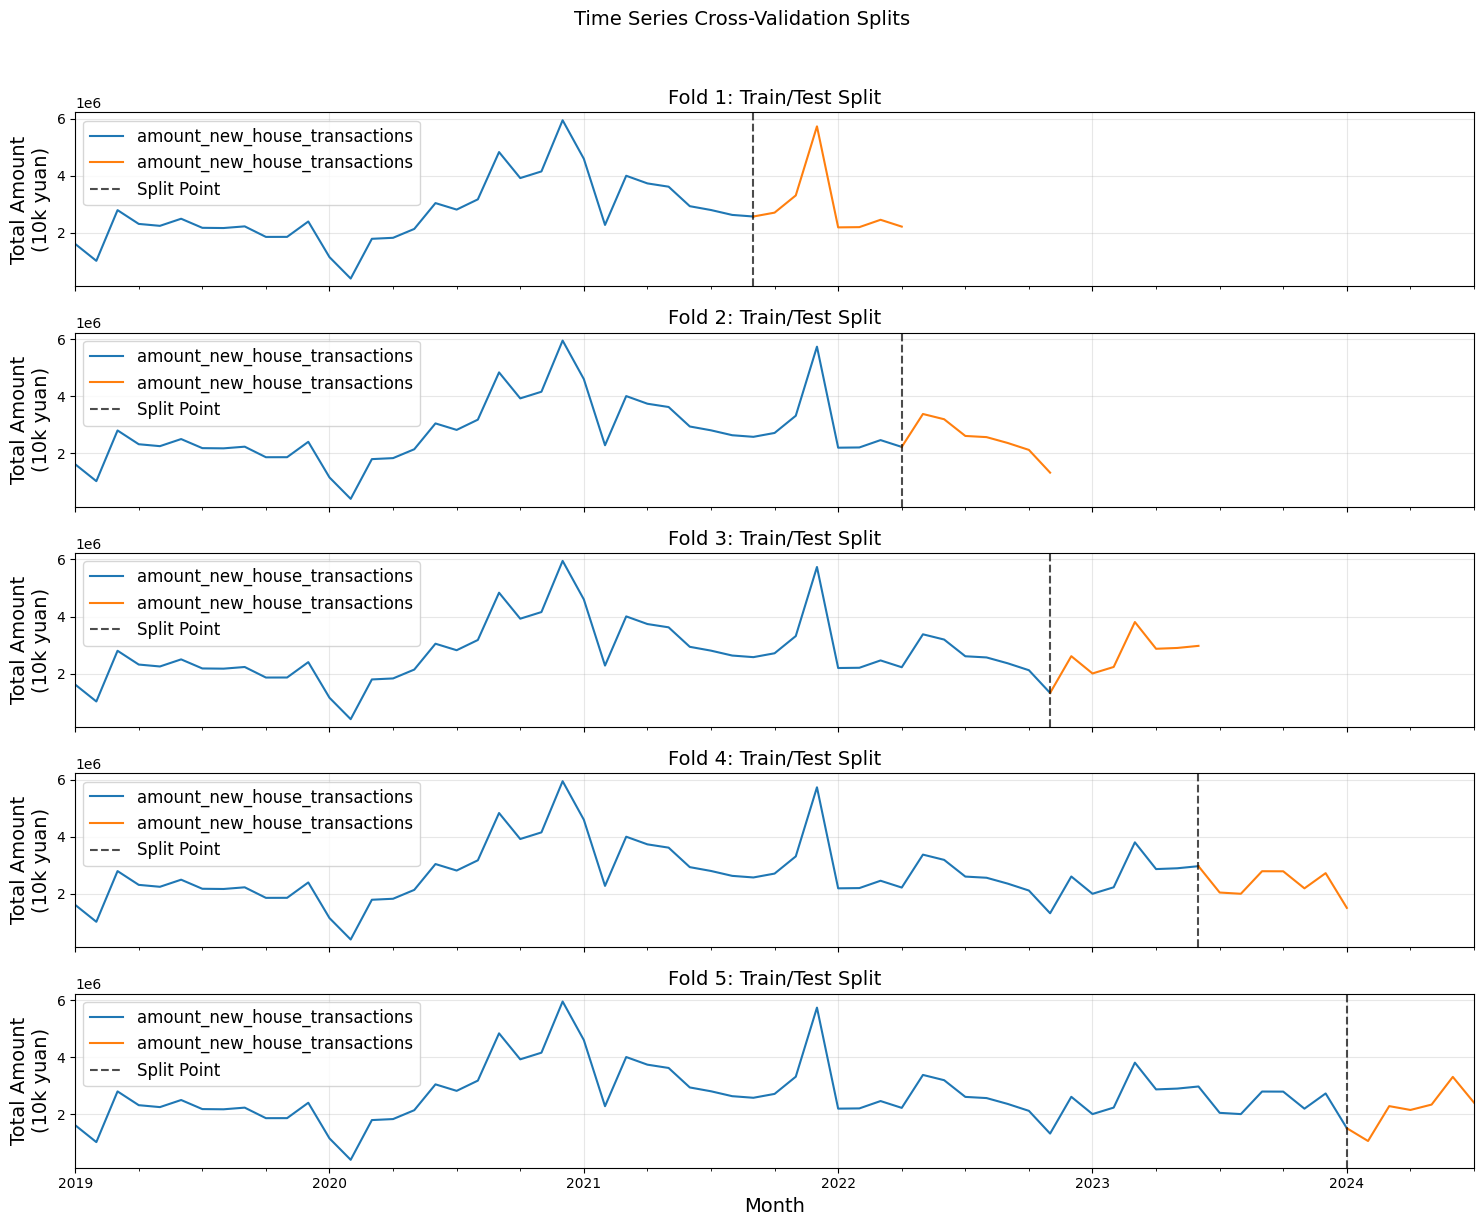


SPLIT STATISTICS

Fold 1:
  Train mean: 33,885
  Test mean:  38,492
  Difference: +13.6%

Fold 2:
  Train mean: 34,718
  Test mean:  31,281
  Difference: -9.9%

Fold 3:
  Train mean: 34,192
  Test mean:  31,237
  Difference: -8.6%

Fold 4:
  Train mean: 33,799
  Test mean:  29,970
  Difference: -11.3%

Fold 5:
  Train mean: 33,350
  Test mean:  26,080
  Difference: -21.8%


In [10]:
# ==========================================
# 4.2 VISUALIZE CROSS-VALIDATION SPLITS
# ==========================================

# Since we have multiple sectors, let's aggregate by month for visualization
monthly_target = df.groupby('month')[target_col].sum().reset_index()
monthly_target = monthly_target.set_index('month').sort_index()

# Create figure
fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Time Series Cross-Validation Splits', fontsize=14, y=1.02)

# Plot each fold
fold = 0
for train_idx, test_idx in tscv.split(X):
    # Get train/test months
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    
    # Filter monthly aggregated data
    train_data = monthly_target[monthly_target.index.isin(train_months)]
    test_data = monthly_target[monthly_target.index.isin(test_months)]
    
    # Plot
    train_data.plot(ax=axes[fold], 
                    label='Training Set',
                    color='#1f77b4',
                    title=f'Fold {fold+1}: Train/Test Split')
    test_data.plot(ax=axes[fold], 
                   label='Test Set',
                   color='#ff7f0e')
    
    # Add vertical line at split point
    axes[fold].axvline(test_data.index.min(), 
                       color='black', 
                       ls='--', 
                       alpha=0.7,
                       label='Split Point')
    
    # Format
    axes[fold].set_ylabel('Total Amount\n(10k yuan)')
    axes[fold].legend(loc='upper left')
    axes[fold].grid(True, alpha=0.3)
    
    fold += 1

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*40)
print("SPLIT STATISTICS")
print("="*40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print(f"\nFold {i+1}:")
    print(f"  Train mean: {train_y.mean():,.0f}")
    print(f"  Test mean:  {test_y.mean():,.0f}")
    print(f"  Difference: {(test_y.mean() - train_y.mean())/train_y.mean()*100:+.1f}%")

# 5. MODELING - LassoCV and Visualisations

In [12]:
# ==========================================
# 5.1 LASSO MODELING WITH CROSS-VALIDATION
# ==========================================

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = [
    'month', 
    'date', 
    'sector', 
    target_col,
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]

feature_cols = [col for col in df.columns if col not in non_features]

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

# Storage for results
fold = 0
preds = []
scores = []
models = []
scalers = []  # Store scalers for each fold
selected_features = []  # Track which features Lasso selects

# Define alpha values to test (regularization strength)
alphas = np.logspace(-4, 2, 100)  # Test 100 alpha values from 0.0001 to 100

for train_idx, test_idx in tscv.split(df):
    print(f"\n--- Fold {fold + 1} ---")
    
    # Split data
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    # Prepare X and y
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    # Handle NaN in target
    train_mask = ~y_train.isna()
    test_mask = ~y_test.isna()
    
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")
    
    # CRITICAL: Handle NaN in features (Lasso doesn't accept NaN)
    print(f"NaN counts before imputation:")
    print(X_train.isna().sum()[X_train.isna().sum() > 0])
    
    # Fill NaN with median for each feature
    for col in feature_cols:
        if X_train[col].isna().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    
    # Verify no NaN remain
    assert X_train.isna().sum().sum() == 0, "Training data still contains NaN!"
    assert X_test.isna().sum().sum() == 0, "Test data still contains NaN!"
    
    # IMPORTANT: Scale features for Lasso (required for L1 regularization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # LassoCV automatically performs cross-validation to find best alpha
    reg = LassoCV(
        alphas=alphas,
        cv=5,  # 5-fold CV within training data
        max_iter=5000,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )
    
    # Train
    reg.fit(X_train_scaled, y_train)
    
    print(f"Best alpha: {reg.alpha_:.4f}")
    print(f"Number of iterations: {reg.n_iter_}")
    
    # Count non-zero coefficients (features selected by Lasso)
    n_features_selected = np.sum(reg.coef_ != 0)
    print(f"Features selected: {n_features_selected}/{len(feature_cols)}")
    
    # Store which features were selected
    selected_mask = reg.coef_ != 0
    selected_features.append({
        'fold': fold + 1,
        'features': [f for f, s in zip(feature_cols, selected_mask) if s],
        'coefficients': reg.coef_[selected_mask]
    })
    
    # Predict
    y_pred = reg.predict(X_test_scaled)
    
    # Clip negative predictions to 0 (transaction amounts can't be negative)
    y_pred = np.maximum(y_pred, 0)
    
    preds.append(y_pred)
    
    # Calculate competition score using custom function
    comp_score = custom_competition_score(y_test.values, y_pred)
    scores.append(comp_score)
    models.append(reg)
    scalers.append(scaler)
    
    # Also calculate RMSE and MAE for reference
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Diagnostic info
    ape = np.abs((y_pred - y_test.values) / y_test.values)
    extreme_pct = 100 * np.sum(ape > 1.0) / len(ape)
    valid_pct = 100 * np.sum(ape <= 1.0) / len(ape)
    
    print(f"Competition Score: {comp_score:.4f}")
    print(f"RMSE: {rmse:,.0f}")
    print(f"MAE: {mae:,.0f}")
    print(f"R²: {r2:.4f}")
    print(f"Samples with APE > 100%: {extreme_pct:.1f}%")
    print(f"Samples with APE ≤ 100%: {valid_pct:.1f}%")
    
    fold += 1

# Summary
print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)
print(f"Average Competition Score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
print(f"Best Competition Score: {np.max(scores):.4f}")
print(f"Worst Competition Score: {np.min(scores):.4f}")

Features: 11
Target: amount_new_house_transactions

--- Fold 1 ---
Train: 2583 | Test: 570
NaN counts before imputation:
num_new_house_available_for_sale_lag1        101
amount_pre_owned_house_transactions_lag1     360
period_new_house_sell_through_lag1           101
sector_historical_mean                        92
sector_historical_std                        183
month_historical_mean                         12
sector_month_avg                            1055
dtype: int64
Best alpha: 100.0000
Number of iterations: 36
Features selected: 11/11
Competition Score: 0.0000
RMSE: 51,247
MAE: 29,642
R²: 0.2042
Samples with APE > 100%: 44.4%
Samples with APE ≤ 100%: 55.6%

--- Fold 2 ---
Train: 3153 | Test: 570
NaN counts before imputation:
num_new_house_available_for_sale_lag1        103
amount_pre_owned_house_transactions_lag1     410
period_new_house_sell_through_lag1           103
sector_historical_mean                        93
sector_historical_std                        185
month_histori


LASSO FEATURE SELECTION ANALYSIS

Features selected in all 5 folds:
  9 features: ['is_december', 'is_february', 'year', 'num_new_house_available_for_sale_lag1', 'amount_pre_owned_house_transactions_lag1', 'period_new_house_sell_through_lag1', 'sector_historical_mean', 'sector_historical_std', 'sector_month_avg']

Features selected in at least 3 folds:
  is_december: 5/5 folds
  is_february: 5/5 folds
  year: 5/5 folds
  num_new_house_available_for_sale_lag1: 5/5 folds
  amount_pre_owned_house_transactions_lag1: 5/5 folds
  period_new_house_sell_through_lag1: 5/5 folds
  sector_historical_mean: 5/5 folds
  sector_historical_std: 5/5 folds
  sector_month_avg: 5/5 folds
  month_historical_mean: 4/5 folds
  months_since_start: 4/5 folds


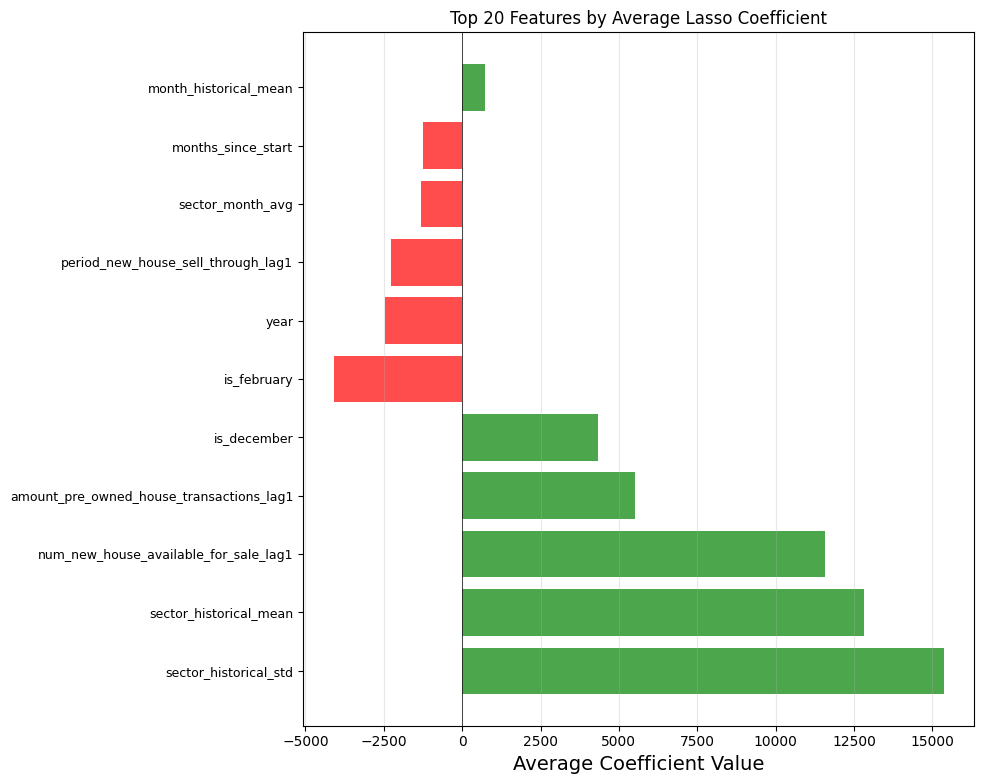

In [13]:
# ==========================================
# 5.2 FEATURE IMPORTANCE ANALYSIS
# ==========================================

print("\n" + "="*60)
print("LASSO FEATURE SELECTION ANALYSIS")
print("="*60)

# Analyze which features were consistently selected across folds
feature_selection_counts = {}
for fold_data in selected_features:
    for feature in fold_data['features']:
        feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Sort by frequency
sorted_features = sorted(feature_selection_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nFeatures selected in all {len(models)} folds:")
always_selected = [f for f, count in sorted_features if count == len(models)]
print(f"  {len(always_selected)} features: {always_selected}")

print(f"\nFeatures selected in at least 3 folds:")
frequently_selected = [f for f, count in sorted_features if count >= 3]
for feature, count in sorted_features:
    if count >= 3:
        print(f"  {feature}: {count}/{len(models)} folds")

# Get average coefficients for frequently selected features
avg_coefficients = {}
for feature in frequently_selected:
    coefs = []
    for fold_data in selected_features:
        if feature in fold_data['features']:
            idx = fold_data['features'].index(feature)
            coefs.append(fold_data['coefficients'][idx])
    avg_coefficients[feature] = np.mean(coefs)

# Plot feature importance (average absolute coefficients)
if avg_coefficients:
    sorted_coefs = sorted(avg_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
    features_plot = [f for f, c in sorted_coefs[:20]]  # Top 20
    coefs_plot = [c for f, c in sorted_coefs[:20]]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['green' if c > 0 else 'red' for c in coefs_plot]
    ax.barh(range(len(features_plot)), coefs_plot, color=colors, alpha=0.7)
    ax.set_yticks(range(len(features_plot)))
    ax.set_yticklabels(features_plot, fontsize=9)
    ax.set_xlabel('Average Coefficient Value')
    ax.set_title('Top 20 Features by Average Lasso Coefficient', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 6. PREDICTING THE FUTURE
Retraining on all data

To Predict the future we need an empty dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

In [ ]:
# ==========================================
# 6. PREDICTIONS FOR SUBMISSION
# ==========================================

# ------------------------------------------
# 6.1 Load and Decode Submission Template
# ------------------------------------------

submission_template = pd.read_csv("/Users/nikola/Python/KaggleCompetition/data/sample_submission.csv")
print(f"Submission shape: {submission_template.shape}")

# Parse the ID format
submission_template['year'] = submission_template['id'].str.split(' ').str[0].astype(int)
submission_template['month_abbr'] = submission_template['id'].str.split('_').str[0].str.split(' ').str[1]
submission_template['sector'] = submission_template['id'].str.split('_').str[1]
submission_template['month'] = pd.to_datetime(
    submission_template['year'].astype(str) + ' ' + submission_template['month_abbr'],
    format='%Y %b'
)

# ------------------------------------------
# 6.2 Prepare Original Features for Future Months
# ------------------------------------------

# Create a dataframe with all sector-month combinations
future_base = submission_template[['month', 'sector']].copy()

# Get the last known values for each sector for the original features
last_values = df.groupby('sector')[['num_new_house_available_for_sale',
                                     'amount_pre_owned_house_transactions', 
                                     'period_new_house_sell_through']].last()

# Merge these values with future months (assume they stay constant)
future_base = future_base.merge(last_values, left_on='sector', right_index=True, how='left')

# For the new sector 95, fill with overall median
for col in ['num_new_house_available_for_sale', 'amount_pre_owned_house_transactions', 'period_new_house_sell_through']:
    future_base.loc[:, col] = future_base[col].fillna(df[col].median())

# ------------------------------------------
# 6.3 Create Combined Dataset
# ------------------------------------------

# Combine historical data with future data
combined = pd.concat([
    df,
    future_base
], ignore_index=True)

combined = combined.sort_values(['sector', 'month']).reset_index(drop=True)

print(f"Combined shape: {combined.shape}")

# ------------------------------------------
# 6.4 Regenerate ALL Features on Combined Dataset
# ------------------------------------------

# Time features
combined['is_december'] = (combined['month'].dt.month == 12).astype(int)
combined['is_february'] = (combined['month'].dt.month == 2).astype(int)
combined['year'] = combined['month'].dt.year

# Lag features (will use historical values for future months)
for feature in ['num_new_house_available_for_sale', 'amount_pre_owned_house_transactions', 'period_new_house_sell_through']:
    combined[f'{feature}_lag1'] = combined.groupby('sector')[feature].shift(1)

# Time series features
combined['sector_historical_mean'] = combined.groupby('sector')[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['sector_historical_std'] = combined.groupby('sector')[target_col].transform(
    lambda x: x.expanding().std().shift(1)
)
combined['month_historical_mean'] = combined.groupby(combined['month'].dt.month)[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['sector_month_avg'] = combined.groupby(['sector', combined['month'].dt.month])[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['months_since_start'] = combined.groupby('sector').cumcount()

# Define features (same as training)
target_col = 'amount_new_house_transactions'
non_features = [
    'month', 'date', 'sector', target_col,
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]
feature_cols = [col for col in combined.columns if col not in non_features]

print(f"\nInitial feature count: {len(feature_cols)}")

# ------------------------------------------
# 6.5 Get Submission Data and Filter Features
# ------------------------------------------

# Get submission rows FIRST
submission_mask = combined['month'].isin(submission_template['month'])
X_submission_temp = combined[submission_mask][feature_cols]

# NOW filter features based on missing data
features_with_data = []
for col in feature_cols:
    missing_pct = X_submission_temp[col].isna().sum() / len(X_submission_temp)
    if missing_pct < 0.9:  # Keep features with <90% missing
        features_with_data.append(col)
    else:
        print(f"Removing {col}: {missing_pct*100:.1f}% missing")

feature_cols = features_with_data
print(f"\nUsing {len(feature_cols)} features after filtering")

# ------------------------------------------
# 6.6 Train Final Model
# ------------------------------------------

train_mask = combined[target_col].notna()
X_train = combined[train_mask][feature_cols].dropna()
y_train = combined[train_mask][target_col].loc[X_train.index]

print(f"\nTraining on {len(X_train)} samples")

# Scale the training data
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)

# Use the average best alpha from CV
avg_alpha = np.mean([m.alpha_ for m in models])
print(f"Using average alpha from CV: {avg_alpha:.4f}")

final_model = Lasso(
    alpha=avg_alpha,
    max_iter=5000,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

print(f"Final model converged in {final_model.n_iter_} iterations")
print(f"Final model selected {np.sum(final_model.coef_ != 0)} features")

# ------------------------------------------
# 6.7 Make Predictions
# ------------------------------------------

# Get submission rows with filtered features
X_submission = combined[submission_mask][feature_cols].copy()

print(f"\nSubmission features - Missing values:")
print(X_submission.isna().sum())

# Fill any remaining NaN with training medians
for col in feature_cols:
    if X_submission[col].isna().any():
        X_submission.loc[:, col] = X_submission[col].fillna(X_train[col].median())

# Scale submission data using the same scaler
X_submission_scaled = final_scaler.transform(X_submission)

# Make predictions
predictions = final_model.predict(X_submission_scaled)

# Clip negative predictions to 0
predictions = np.maximum(predictions, 0)

print(f"\nPredictions:")
print(f"  Min: {predictions.min():,.0f}")
print(f"  Max: {predictions.max():,.0f}")
print(f"  Mean: {predictions.mean():,.0f}")
print(f"  Median: {np.median(predictions):,.0f}")
print(f"  Non-zero: {(predictions > 0).sum()}/{len(predictions)}")

# Create submission
submission_template['amount'] = predictions
submission_template[['id', 'amount']].to_csv("/Users/nikola/Python/KaggleCompetition/output/11_LASSO/submission.csv", index=False)
print("\n✓ Submission file saved!")

# ------------------------------------------
# 6.8 Compare Lasso vs XGBoost (Optional)
# ------------------------------------------

print("\n" + "="*60)
print("LASSO MODEL CHARACTERISTICS")
print("="*60)
print("\nKey differences from XGBoost:")
print("1. Linear model vs tree-based ensemble")
print("2. Automatic feature selection via L1 regularization")
print("3. Requires feature scaling (StandardScaler applied)")
print("4. More interpretable coefficients")
print("5. May struggle with non-linear relationships")
print("\nLasso is particularly useful when:")
print("- You need interpretability")
print("- You suspect many features are irrelevant")
print("- You want automatic feature selection")
print("- Linear relationships dominate the data")

Submission shape: (1152, 2)
Combined shape: (6585, 17)

Initial feature count: 11

Using 11 features after filtering

Training on 3826 samples
Using average alpha from CV: 100.0000
Final model converged in 56 iterations
Final model selected 11 features

Submission features - Missing values:
is_december                                  0
is_february                                  0
year                                         0
num_new_house_available_for_sale_lag1        3
amount_pre_owned_house_transactions_lag1    16
period_new_house_sell_through_lag1           3
sector_historical_mean                      12
sector_historical_std                       24
month_historical_mean                        0
sector_month_avg                            37
months_since_start                           0
dtype: int64

Predictions:
  Min: 0
  Max: 167,581
  Mean: 21,040
  Median: 11,387
  Non-zero: 820/1152

✓ Submission file saved!

LASSO MODEL CHARACTERISTICS

Key differences from XGBoost:
1